## Random Forrest

In [26]:
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import os
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage import exposure
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [27]:
df = pd.read_csv('data/train.csv')

In [28]:
df

,im_name,label
0,00016cd.jpg,6
1,0001808.jpg,2
2,0002399.jpg,1
3,0003973.jpg,3
4,00061cc.jpg,4
...,...,...
49995,d5992c0.jpg,7
49996,d599cf6.jpg,9
49997,d59a4c9.jpg,5
49998,d59c7f5.jpg,9


In [39]:
df = df.sample(frac=0.1, random_state=42)

In [40]:
def read_image(path: str):
    return Image.open(path)

In [41]:
img = read_image('data/train_ims/d59d147.jpg')
img.size

(32, 32)

# 1. Dataset Analysis

### Statistics on the number of categories

In [42]:
# Total number of unique categories

num_categories = df['label'].nunique()
print(f"Number of unique categories: {num_categories}")

Number of unique categories: 10


In [43]:
# Number of images per category

df['label'].value_counts().sort_index()

label
0    486
1    509
2    501
3    510
4    507
5    506
6    498
7    501
8    474
9    508
Name: count, dtype: int64

### Visualization of example per category

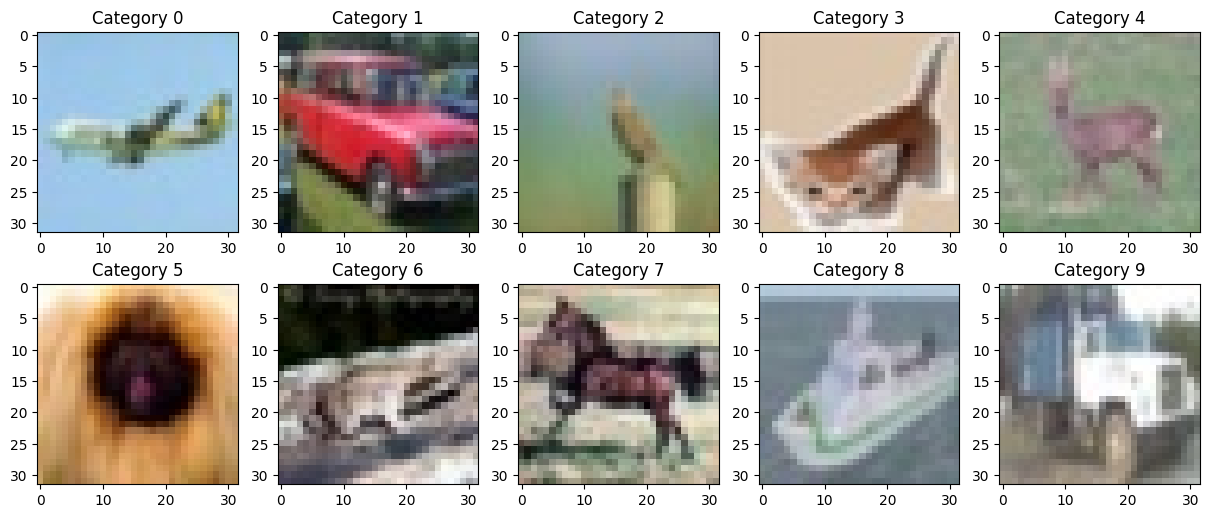

In [45]:
example_per_category = df.groupby('label').first().reset_index()
num_categories = example_per_category.shape[0]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for idx, (i, row) in enumerate(example_per_category.iterrows()):
    row_idx = idx // 5
    col_idx = idx % 5
    ax = axes[row_idx, col_idx]

    img = read_image(os.path.join('data', 'train_ims', row['im_name']))
    ax.imshow(img)
    ax.set_title(f"Category {row['label']}")

In [46]:
def extract_features(image):
    gray_img = rgb2gray(image)
    equalized_img = exposure.equalize_hist(gray_img)
    features = hog(
        equalized_img,
        orientations=9,
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        block_norm='L2-Hys',
        visualize=False
    )
    return features

# Train

In [47]:
features_list = []
labels = []
IMG_DIR = 'data/train_ims'

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    img_path = os.path.join(IMG_DIR, row['im_name'])
    img = imread(img_path)

    features = extract_features(img)
    features_list.append(features)
    labels.append(row['label'])

100%|██████████| 5000/5000 [00:07<00:00, 687.28it/s]


In [48]:
# X = np.array(features_list)
# y = np.array(labels)
X = np.array(features_list)
y = np.array(labels)

In [49]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize features
scaler          = MinMaxScaler()
X_train_norm    = scaler.fit_transform(X_train)
X_val_norm      = scaler.transform(X_val)


In [22]:
# Training on normalized data
clf = SVC(kernel='rbf', C=5.0, gamma='scale', random_state=42)
clf.fit(X_train_norm, y_train)

In [52]:
# Training on random forrest classifier
# Training on random forrest classifier
for n_estimator in [175, 200, 225, 250, 275, 300]:
    rf = RandomForestClassifier(n_estimators=n_estimator, random_state=42)
    rf.fit(X_train_norm, y_train)
    y_pred = rf.predict(X_val_norm)
    score = accuracy_score(y_val, y_pred)
    print(score)

# Tuning
# Best n_estimator = 250
    

0.453
0.451
0.461
0.463
0.466
0.461


In [19]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [14]:
clf = SVC(kernel='rbf', C=5.0, gamma='scale', random_state=42)
clf.fit(X_train, y_train)

SVC(C=5.0, random_state=42)

In [16]:
# y_pred = clf.predict(X_val)
y_pred = rf.predict(X_val_norm)

In [17]:
accuracy = accuracy_score(y_val, y_pred)
print(f'Validation accuracy: {accuracy}')

Validation accuracy: 0.456
